In [10]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [1]:
#drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
IMAGE_SIZE = [224, 224]

In [3]:
from glob import glob
folders = glob('/content/drive/MyDrive/xray_extracted/xray/train/*')

print(type(folders))
print(folders)
len(folders)

<class 'list'>
['/content/drive/MyDrive/xray_extracted/xray/train/NORMAL', '/content/drive/MyDrive/xray_extracted/xray/train/PNEUMONIA']


2

In [4]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [7]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [8]:
resnet.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [11]:
x = Flatten()(resnet.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
from keras import optimizers
import tensorflow as tf


adam = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [13]:
#training data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#validation data augmentation
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/xray_extracted/xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory('/content/drive/MyDrive/xray_extracted/xray/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4708 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [19]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/xray_resnett.h5', 
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=valid_set,
  epochs=5,
  steps_per_epoch=len(train_set),
  validation_steps=len(valid_set),
    callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5

Epoch 00001: val_loss improved from inf to 0.17899, saving model to /content/drive/MyDrive/xray_resnett.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


148/148 - 157s - loss: 0.1837 - accuracy: 0.9257 - val_loss: 0.1790 - val_accuracy: 0.9275 - 157s/epoch - 1s/step
Epoch 2/5

Epoch 00002: val_loss did not improve from 0.17899
148/148 - 156s - loss: 0.1797 - accuracy: 0.9244 - val_loss: 0.2671 - val_accuracy: 0.8969 - 156s/epoch - 1s/step
Epoch 3/5

Epoch 00003: val_loss improved from 0.17899 to 0.16012, saving model to /content/drive/MyDrive/xray_resnett.h5
148/148 - 165s - loss: 0.1656 - accuracy: 0.9367 - val_loss: 0.1601 - val_accuracy: 0.9351 - 165s/epoch - 1s/step
Epoch 4/5

Epoch 00004: val_loss improved from 0.16012 to 0.15741, saving model to /content/drive/MyDrive/xray_resnett.h5
148/148 - 168s - loss: 0.2045 - accuracy: 0.9208 - val_loss: 0.1574 - val_accuracy: 0.9447 - 168s/epoch - 1s/step
Epoch 5/5

Epoch 00005: val_loss did not improve from 0.15741
148/148 - 156s - loss: 0.1698 - accuracy: 0.9322 - val_loss: 0.1935 - val_accuracy: 0.9332 - 156s/epoch - 1s/step
Training completed in time:  0:14:09.645129


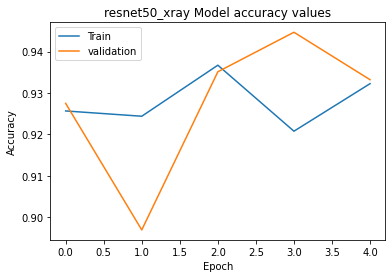

In [20]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('resnet50_xray Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

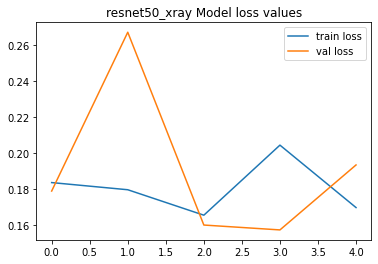

<Figure size 432x288 with 0 Axes>

In [27]:
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.title('resnet50_xray Model loss values')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [24]:
from keras.models import load_model
resnet_xray = load_model('/content/drive/MyDrive/xray_resnett.h5')

In [25]:
test_gen= ImageDataGenerator(rescale = 1./255)
test_set=test_gen.flow_from_directory('/content/drive/MyDrive/xray_extracted/xray/train', target_size=(224, 224), shuffle=False)
steps_per_epoch_test=len(test_set)

Found 4708 images belonging to 2 classes.


In [26]:
t= resnet_xray.evaluate_generator(test_set, steps_per_epoch_test, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


148/148 [==============================] - 72s 472ms/step - loss: 0.1784 - accuracy: 0.9437


In [30]:

pred=resnet_xray.predict(test_set,verbose=1)



148/148 [==============================] - 70s 473ms/step
